In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek
from sklearn.preprocessing import normalize
from sklearn import neighbors, ensemble, tree, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, RandomizedSearchCV

import warnings 
warnings.simplefilter('ignore')

# Import Data

In [52]:
#import data
customers = pd.read_csv('customers_data.csv',index_col=0)

# re-engineer features
customers['gender'] = np.where(customers['gender'] == 'male',1,0) #1 indicates male, 0 indicates female
customers['card_on_file'] = np.where(customers['card_on_file'] == 'yes',1,0) #1 indicates yes, 0 indicates no
customers['loyalty'] = np.where(customers['loyalty'] == False,0,1) #1 indicates loyal, 0 indicates not loyal

#print head
print(customers.head())
#check for null values
print(customers.info())

   purch_amt  gender  card_on_file   age  days_since_last_purch  loyalty
0      19.58       1             0  31.0                   35.0        0
1      65.16       1             1  23.0                   61.0        0
2      40.60       0             0  36.0                   49.0        0
3      38.01       1             1  47.0                   57.0        0
4      22.32       0             1   5.0                   39.0        0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 119999
Data columns (total 6 columns):
purch_amt                120000 non-null float64
gender                   120000 non-null int64
card_on_file             120000 non-null int64
age                      120000 non-null float64
days_since_last_purch    120000 non-null float64
loyalty                  120000 non-null int64
dtypes: float64(3), int64(3)
memory usage: 6.4 MB
None


In [53]:
#check for uneven class, looks like 1/6 minority for loyal
customers.loyalty.value_counts()

0    100000
1     20000
Name: loyalty, dtype: int64

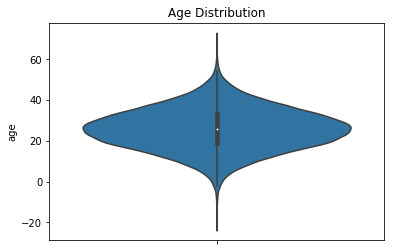

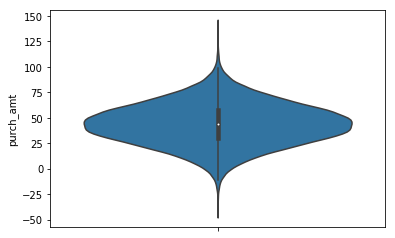

In [66]:
#check customer age distribution
sns.violinplot(y=customers['age'])
plt.title('Age Distribution')
plt.show()
#check the distribution of purch_amt
sns.violinplot(y=customers['purch_amt'])
plt.show('Purchase Amount Distribution')
plt.show()

In [67]:
#check class balance of output
print(customers['loyalty'].value_counts())

0    100000
1     20000
Name: loyalty, dtype: int64


In [55]:
# Define the features and the outcome.
X = customers.drop(['loyalty'],axis=1)
X = normalize(X)
y = customers['loyalty']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=y)

In [56]:
#class balancing
smt = SMOTETomek(random_state=42)
#class balancing
#only perform on the training set, this reduces bias in fitting the model.
X_res, y_res = smt.fit_resample(X_train, y_train)


In [57]:
pd.Series(y_res).value_counts()


1    71821
0    71821
dtype: int64

# Modeling

In [58]:
#iterate through the models
models = []
models.append(('RFC', ensemble.RandomForestClassifier()))
models.append(('KNN', neighbors.KNeighborsClassifier()))
models.append(('DTC', tree.DecisionTreeClassifier()))
models.append(('GBC', ensemble.GradientBoostingClassifier()))
models.append(('ABC', ensemble.AdaBoostClassifier()))
models.append(('ETC', ensemble.ExtraTreesClassifier()))

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

# evaluate each model in turn
results = []
names = []
for name, model in models:
    model = model.fit(X_res,y_res)
    cv_results = cross_val_score(model, X_test, y_test, cv=split, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RFC: 0.848867 (0.006320)
KNN: 0.852000 (0.005922)
DTC: 0.808867 (0.009394)
GBC: 0.868733 (0.006499)
ABC: 0.865400 (0.006958)
ETC: 0.842400 (0.008051)


Looks like GradientBoostClassifier out performs the other models, let's see if we can tune it to get even better performance!

In [59]:
print('Processing...')

# Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         ensemble.GradientBoostingClassifier())

# Declare hyperparameters to tune
hyperparameters = {'gradientboostingclassifier__n_estimators' : [100,500,1000],
                  'gradientboostingclassifier__max_depth' : [2,3,4,5,6,7],
                  'gradientboostingclassifier__max_features': [1,2,3,4,5],
                  'gradientboostingclassifier__loss': ['deviance', 'exponential'],
                  'gradientboostingclassifier__random_state': [1337],
                  'gradientboostingclassifier__warm_start': [True],
                  'gradientboostingclassifier__n_iter_no_change' : [None, 1]
                  }
 
# Tune model using cross-validation pipeline
gbc = RandomizedSearchCV(estimator=pipeline,param_distributions=hyperparameters, cv=split)
gbc.fit(X_res, y_res)
                                               
# Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
print('Best Parameters:\n ', gbc.best_params_)


Processing...
Best Parameters:
  {'gradientboostingclassifier__warm_start': True, 'gradientboostingclassifier__random_state': 1337, 'gradientboostingclassifier__n_iter_no_change': None, 'gradientboostingclassifier__n_estimators': 1000, 'gradientboostingclassifier__max_features': 3, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__loss': 'deviance'}


In [60]:
# Evaluate model pipeline on test data
print('\nTraining Accuracy:\n   ', gbc.score(X_res, y_res))
print('Testing Accuracy:\n   ', gbc.score(X_test, y_test))

score = cross_val_score(gbc, X_test, y_test, cv=split)
print('\nCross Validation:\n    %0.2f +/- %0.2f' %(score.mean(),score.std()))


Training Accuracy:
    0.8715974436446164
Testing Accuracy:
    0.8019

Cross Validation:
    0.87 +/- 0.01


In [61]:
GBC = ensemble.GradientBoostingClassifier(n_estimators=1000,
                                    max_features=3,
                                    max_depth=5,
                                    loss = 'deviance',
                                    n_iter_no_change=None,
                                    random_state=1337,
                                    warm_start=True)
GBC.fit(X_res,y_res)
cv_results = cross_val_score(GBC, 
                             X_test, 
                             y_test, 
                             cv=split,
                             scoring='accuracy')


print(f'GBC test score: {round(cv_results.mean(),4)}, STD: {round(cv_results.std(),4)}')


GBC test score: 0.8547, STD: 0.0066


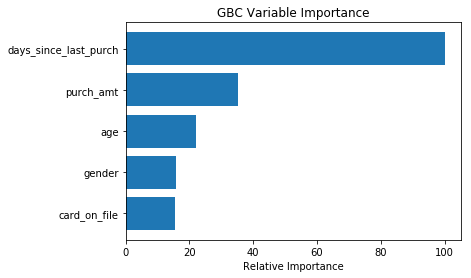

In [89]:
feature_importance = GBC.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, customers.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('GBC Variable Importance')
plt.show()